<h1><center>Facies Classification using Machine Learning</center></h1>

<font size="3">Written by Ibinabo Bestmann</font>

Facies are uniform sedimentary bodies of rock which are distinguishable enough from each other in terms of physical characteristics (e.g. sedimentary structure, grain sizes), deposited under the action of a relatively uniform hydrodynamic regime in a given depositional setting. The different types of facies based on these properties include sedimentary facies, lithofacies, seismic facies, etc.

The physical and organic characteristics found in these rock units usually provide some insight into the different process and systems (e.g. depositional environments) which may have occurred in the region. Combinations of several facies with physical models and other geological data can help provide informative low-dimensional models of the geologic region, leading to better insights regarding the geology of the region.

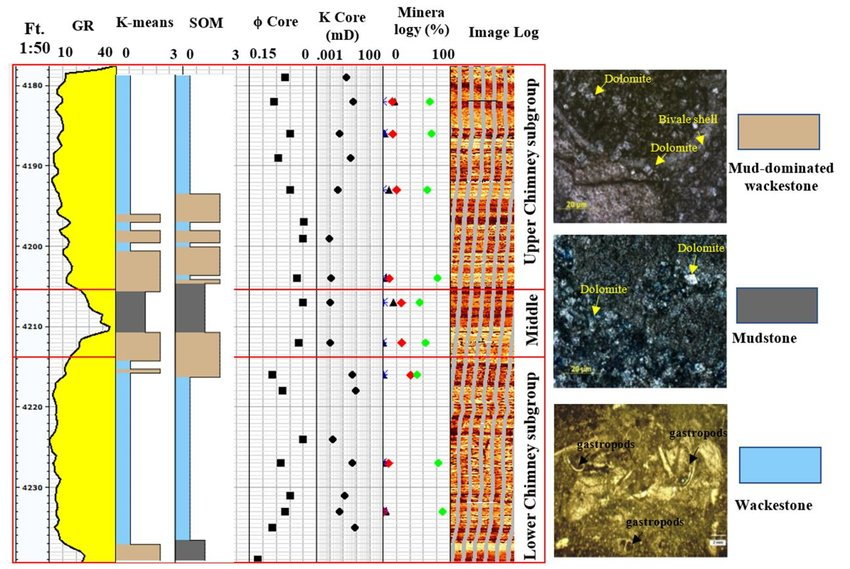

Taken from [researchgate](https://www.researchgate.net/publication/333648862_Integrated_reservoir_characterization_and_geological_upscaling_for_reservoir_flow_simulations_of_the_SycamoreMeramec_and_Hunton_Plays_in_Oklahoma/figures?lo=1): Lithofacies classification in a well using well logs, borehole images and thin sections

In oil and gas exploration, knowledge of the depositional environment is vital as it can help in providing a decent picture of the petroleum systems involved. A petroleum system consists of source rocks (organic matter rich rocks which generate hydrocarbons if heated sufficiently), reservoir rocks (set of rock units that holds hydrocarbon reserves which migrate from the source rock), and seal rock (relatively impermeable rock units that form a barrier around reservoir rocks, preventing hydrocarbon migration beyond the reservoir). A succession of facies with sandstone units, for instance, might be an indicator of a good reservoir, as they tend to have high permeability and porosity, ideal conditions to store hydrocarbons. A common rule known as Walther’s Law of facies stipulates that vertical succession of facies reflects lateral changes in the depositional environment i.e. Two adjacent facies within the rock record must have been deposited laterally in formation. Therefore, the amount of hydrocarbon in place may be estimated by observing the lateral extent and geometries of the facies containing the reservoir units.

The main sources of data with regards to sub-surface rocks come from a variety of sources, most of which involve drilling. The ideal source of data for facies classification is core (rock) samples obtained from drilled wells as they allow for direct assessment of the sedimentary structure. However, these are expensive to obtain and are not always a feasible option in some cases due to costs. In these situations, indirect measurements are necessary. In this study, I will focus on wireline logs. Wireline logging involves the process of lowering instruments into a borehole and recording measurements that detail the physical characteristics of the surrounding rock and fluids with depth. It is a means of assessing reservoirs since it aids in the differentiation between oil, gas, and water containing formations, determination of porosity, as well as the approximate amount of hydrocarbons present in each formation.

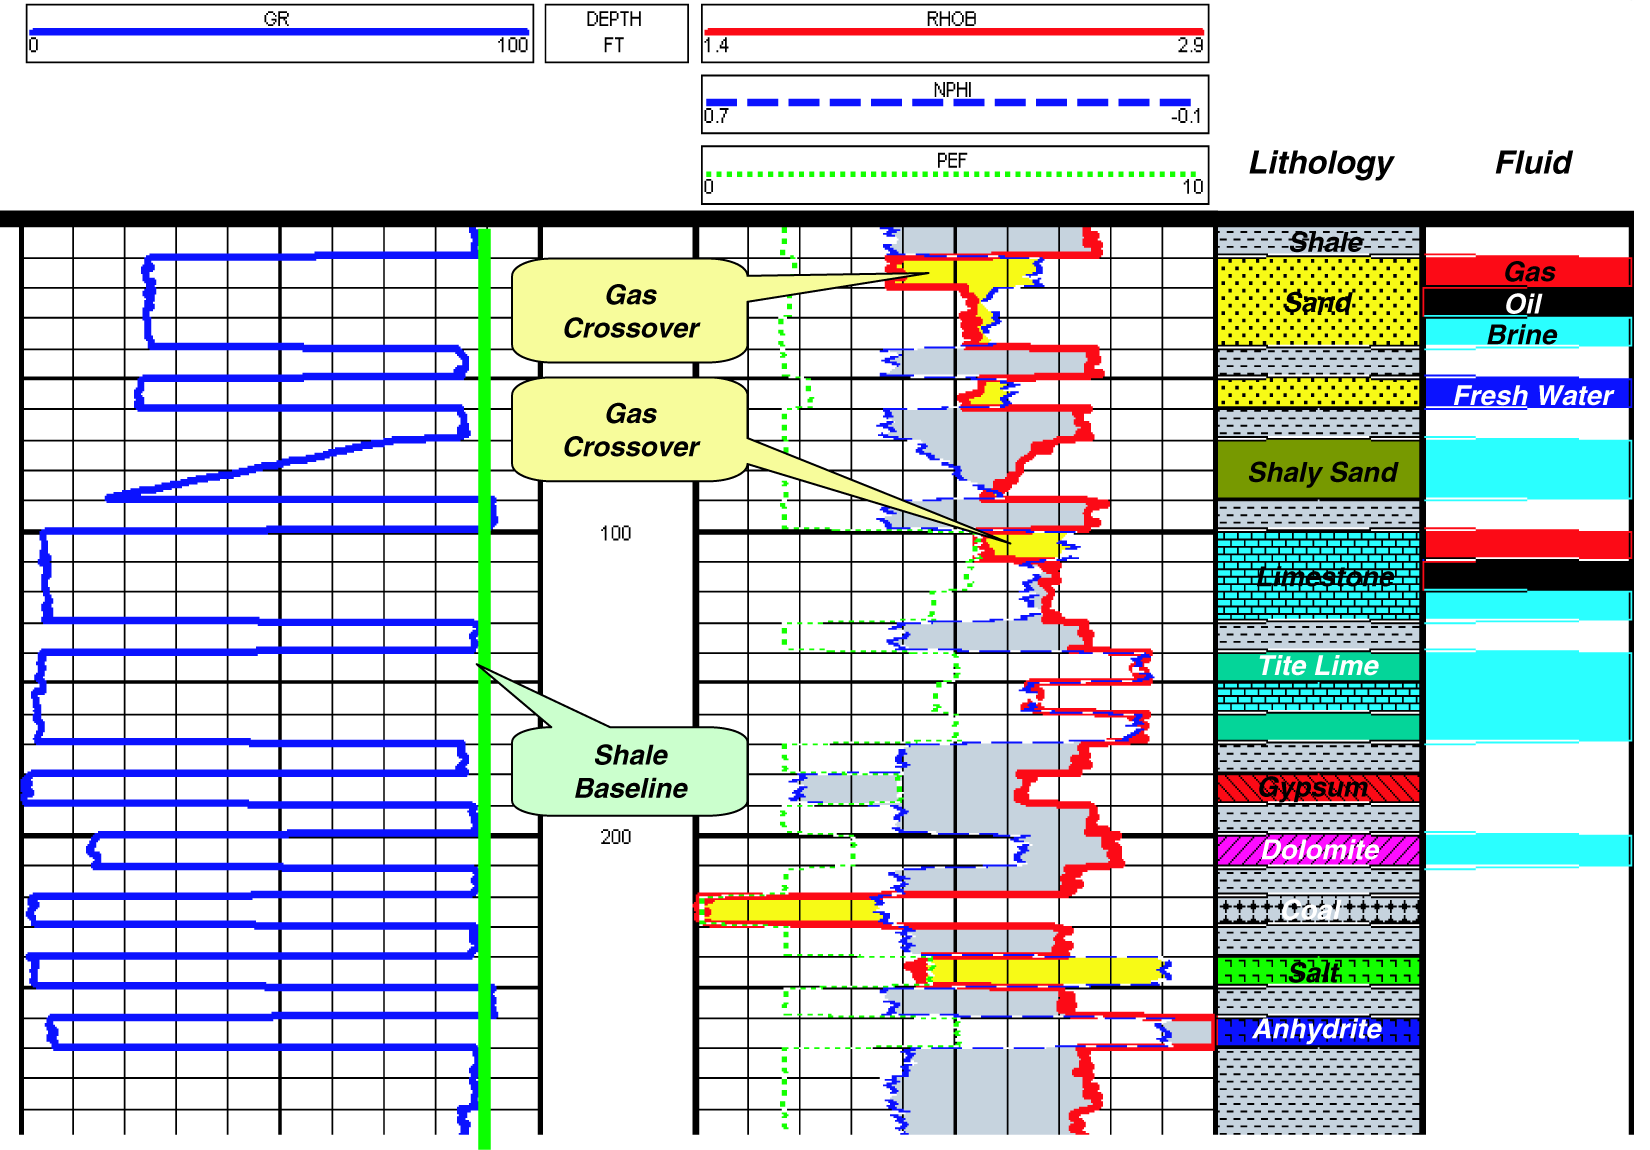

Taken from [petrowiki](https://petrowiki.org/Neutron_porosity_logs): Schematic well-log responses for some common lithologies.

In order to assign facies using log data, an analyst is required to analyze the records and determine the approximate lithology with depth. With larger datasets, this can become quite tedious and very inefficient in terms of time. Automation of this procedure is therefore necessary and may be helpful in giving a quick and reasonably accurate picture of the regional geology. This could potentially reduce processing time of analysis and serve as a guide for supervised classification. I will demonstrate how unsupervised learning can help with this process using K-means clustering. 

## Study area

Our analysis is concentrated to the northwestern region of Kansas, USA. I will attempt to create a reservoir model of the Forest city coal gas area, located in the Forest City basin. This basin has predominantly been a shallow oil and gas province with some coal production.

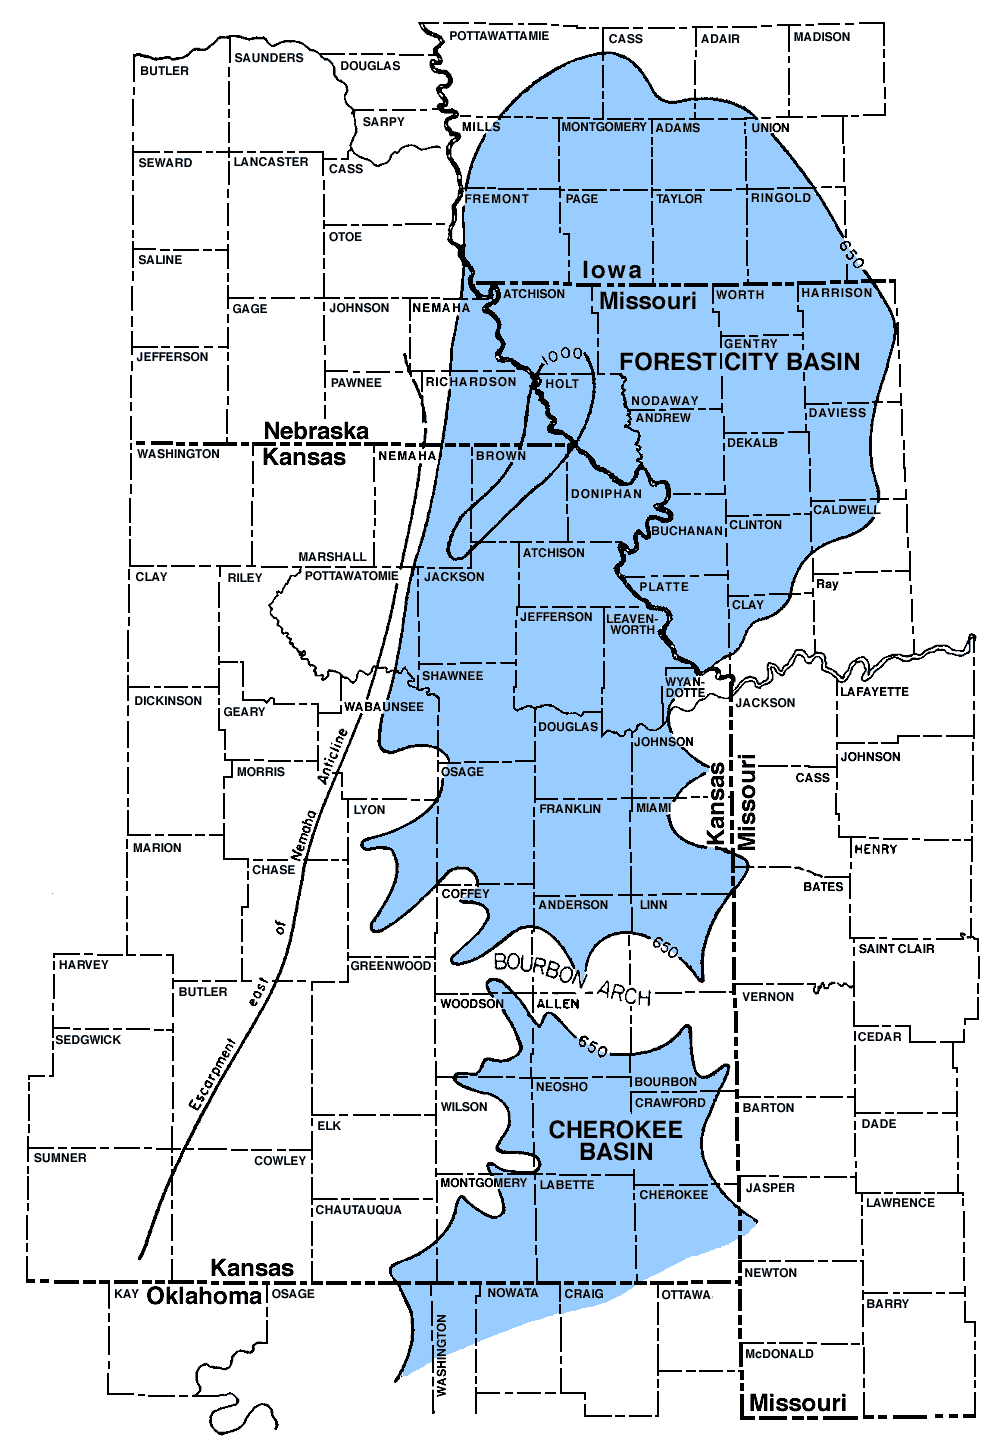

Taken from [KGS geology](http://www.kgs.ku.edu/Publications/Bulletins/51/02_intro.html): Map showing the major topographic basins in Midwest USA

The regions highlighted in blue in figure 1 outline the major hydrocarbon producing regions. My focus was on the Nemaha region within the Forest city basin, which is known to have occurrences of oil and gas and had a couple of wells drilled there. The data was obtained courtesy of the Kansas geological survey which has public records for different wells in the region (Please see https://www.shalexp.com/kinney-oil-company for more details on wells). A sample of some oil and gas wells in this region are shown below

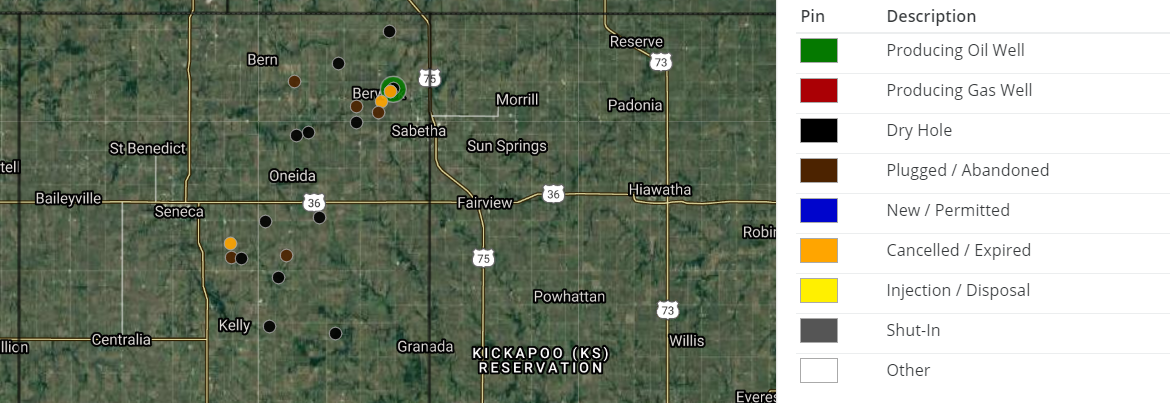

Taken from [shalexp](https://www.shalexp.com/kinney-oil-company): Distribution of hydrocarbon wells in Nemaha county, Kansas.

The well logs were obtained in LAS file format from [here](http://www.kgs.ku.edu/PRS/Scans/Log_Summary/index.html), and were examined for data quality and completeness. A criterion for selection was the presence of eight curves which I deemed necessary for the analysis. Table 1 shows the associated curves and the properties they provide about the rock formation. These values are all a function of depth measured in feet.  

| Well log  | Units | Physical Measurement | Properties |
| :-: | :-: | :-: | :-: |
| Gamma Ray (GR) | gAPI | Natural radioactivity of the formation | Strong indicator for clays as they tend to have higher gamma readings due to presence of radioactive potassium, and their ability to adsorb uranium and thorium (radioactive elements)
| Deep Induction R conductivity (CILD) | mMHO | Conductivity of a formation | Hydrocarbons tend to have lower conductivities, while fluids have higher conductivities. Useful for estimating water saturation
| Phased deep induction resistivity (ILD)| Ω/m | Resistivity of a formation | Inverse of conductivity
| Compensated Neutron Porosity (NPLS)| % | Hydrogen concentration in a formation | Strongly affected by clay and gas since they have higher hydrogen content, resulting in lower apparent porosity. Usually scaled in terms of a limestone matrix and water-filled porosity. 
| Compensated Sonic Delta Time (DT) | µs/ft | Formation’s interval time (capacity to transmit seismic waves) | Decreases with increase in porosity e.g. sandstones. 
| Lithology Density (RHOB) | g/cc| Measures count of gamma rays at a distant detector, which is inversely proportional to electron density of rock and proportional to actual rock density.  | Can differentiate between low density shale, and higher density non-shale formations. 
| Photo Absorption Factor | b/E (barns/electron) | Count rate of soft gamma rays | Gives a measure of the rock matrix properties thus allowing for mineral determination. Sensitive to presence of limestone/dolomites, clays and heavy minerals which tend to have higher values. Higher values tend to indicate presence of igneous or metamorphic rocks, while lower values may indicate coal. 
| Spontaneous Potential (SP)|mV | Measures electric potential of formation |Good indicator of permeable bed especially at sand/shale interfaces. Can help in estimating resistivity.

Using a wide array of logs is useful as they not only provide information on properties such as the lithology, porosity, and electrical conductivity of a formation, but used in conjunction with each other, can boost the accuracy of lithology estimation by performing better in situations where individual logs might fail. I analyzed several of the wells and was able to obtain 6 wells with the required curves available. These curves from the different wells were then combined into a single CSV file for processing. The well names and the formation at each depth were also included. The formation information was obtained at http://www.kgs.ku.edu/Magellan/Qualified/index.html. Oil wells belonging to Kinney Oil were used for this study. 

## Data cleaning and pre-processing

In [1]:
import pandas as pd
import glob 
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
df = pd.read_csv('Kinney_oil_ML.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32768 entries, 0 to 32767
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  32768 non-null  int64  
 1   DEPT        32768 non-null  float64
 2   GR          31757 non-null  float64
 3   CILD        32163 non-null  float64
 4   RHOB        31667 non-null  float64
 5   NPLS        31617 non-null  float64
 6   PE          31667 non-null  float64
 7   ILD         32163 non-null  float64
 8   SP          32180 non-null  float64
 9   DT          32298 non-null  float64
 10  Formation   32768 non-null  object 
 11  Well name   32768 non-null  object 
dtypes: float64(9), int64(1), object(2)
memory usage: 3.0+ MB


In [3]:
df.describe()

,Unnamed: 0,DEPT,GR,CILD,RHOB,NPLS,PE,ILD,SP,DT
count,32768.000000,32768.000000,31757.000000,32163.000000,31667.000000,31617.000000,31667.000000,32163.000000,32180.000000,32298.000000
mean,16383.500000,1774.398962,74.596032,160.315284,2.465206,22.153560,3.259100,24.944525,214.757612,300.505662
std,9459.451147,1045.148279,50.840228,141.632553,0.199127,12.305607,0.857486,240.200393,140.868459,386.941978
min,0.000000,181.500000,4.370000,0.100000,1.160000,-0.490000,1.340000,0.790000,-57.670000,-1.997700
25%,8191.750000,892.475000,27.000000,44.980000,2.370000,12.100000,2.720000,4.260000,50.460000,68.052250
50%,16383.500000,1617.450000,72.180000,122.500000,2.490000,22.480000,3.100000,8.160000,278.770000,96.875000
75%,24575.250000,2573.625000,111.400000,234.605000,2.610000,31.480000,3.590000,22.240000,334.920000,145.645000
max,32767.000000,4003.500000,597.490000,1267.100000,2.990000,68.540000,11.880000,10000.000000,403.740000,999.000000


Note: Value of 999 also indicates missing data, this was only seen in the DT log. Let's begin the data processing step by comparing how much of the data was missing

In [4]:
df.isna().sum()

Unnamed: 0       0
DEPT             0
GR            1011
CILD           605
RHOB          1101
NPLS          1151
PE            1101
ILD            605
SP             588
DT             470
Formation        0
Well name        0
dtype: int64

The missing values not represented by 999 account for a small percentage of the data set. Let's remove those values

In [5]:
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)

Next, we remove the values denoted by 999 

In [6]:
df["DT"].replace({999: np.nan}, inplace=True)
df.dropna(inplace=True)

Perform a final check for missing values

In [7]:
df.isna().sum()

Unnamed: 0    0
DEPT          0
GR            0
CILD          0
RHOB          0
NPLS          0
PE            0
ILD           0
SP            0
DT            0
Formation     0
Well name     0
dtype: int64

In [8]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [9]:
df.describe()

,DEPT,GR,CILD,RHOB,NPLS,PE,ILD,SP,DT
count,23811.000000,23811.000000,23811.000000,23811.000000,23811.000000,23811.000000,23811.000000,23811.000000,23811.000000
mean,1712.859800,75.687987,151.666775,2.487865,21.492102,3.319850,24.761973,270.004786,86.487682
std,977.354101,52.016715,137.251380,0.160521,12.030621,0.775952,207.749669,117.143200,26.538016
min,248.000000,4.370000,0.100000,1.370000,-0.490000,1.340000,0.790000,-57.670000,38.840000
25%,904.000000,26.810000,43.325000,2.390000,11.900000,2.800000,4.690000,251.340000,63.056650
50%,1544.000000,73.490000,115.260000,2.500000,21.570000,3.210000,8.680000,301.040000,85.100000
75%,2370.500000,114.105000,213.450000,2.610000,30.340000,3.710000,23.090000,354.980000,104.650000
max,3938.000000,597.490000,1267.100000,2.990000,57.780000,11.880000,10000.000000,403.740000,214.460000


## Removing outliers

The descriptive variables outlined some potential outliers present. We plot the curves for visual inspection

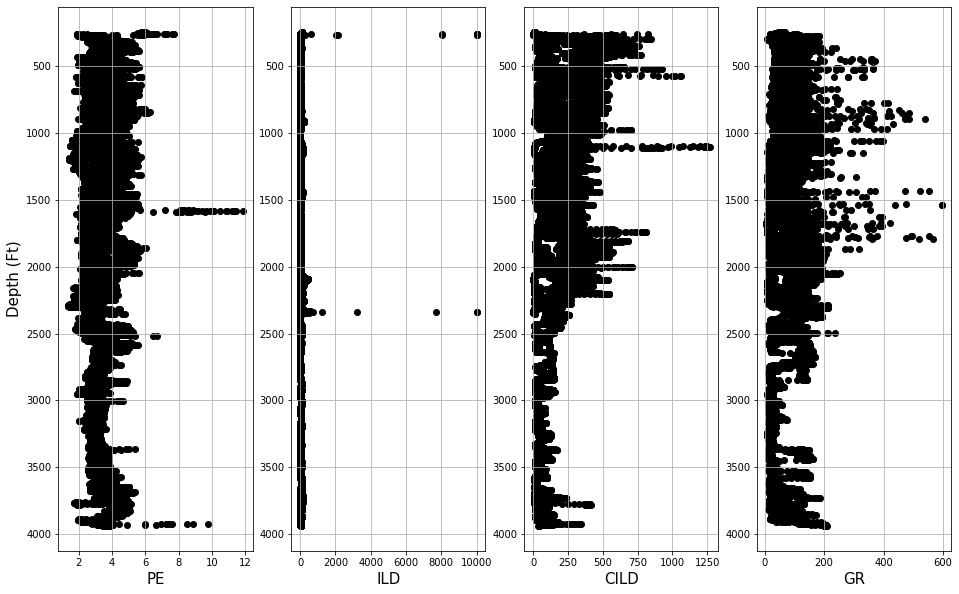

In [10]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(16,10),linewidth=3)

curves = ['PE','ILD','CILD','GR']

for i in range(len(curves)):
    ax[i].scatter(df[curves[i]],df['DEPT'],c='k')
    ax[i].set_xlabel(curves[i],fontsize=15)
    ax[0].set_ylabel('Depth (Ft)',fontsize=15)
    ax[i].yaxis.grid(True)
    ax[i].xaxis.grid(True)
    ax[i].invert_yaxis()

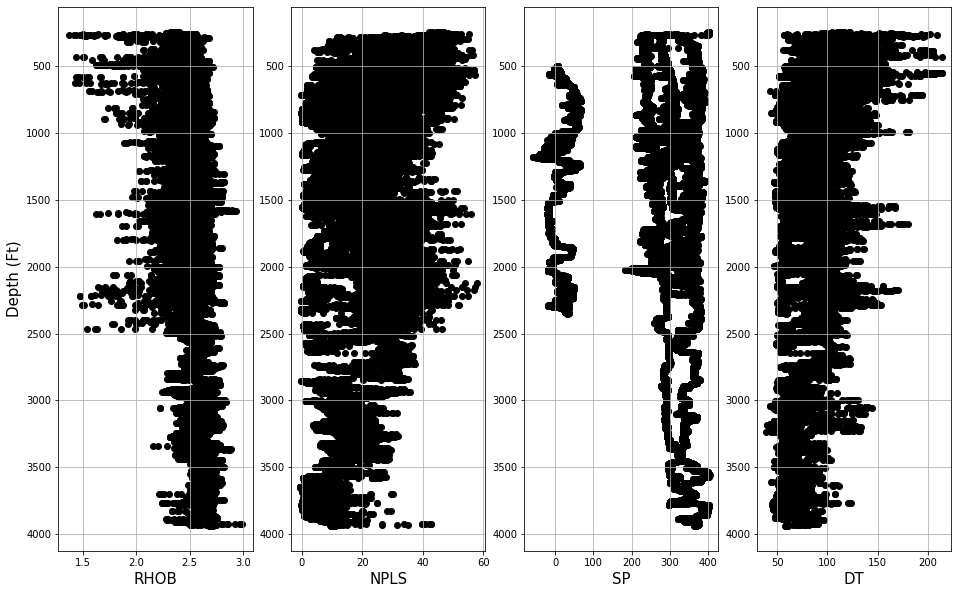

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(16,10),linewidth=3)

curves = ['RHOB','NPLS','SP','DT']

for i in range(len(curves)):
    ax[i].scatter(df[curves[i]],df['DEPT'],c='k')
    ax[i].set_xlabel(curves[i],fontsize=15)
    ax[0].set_ylabel('Depth (Ft)',fontsize=15)
    ax[i].yaxis.grid(True)
    ax[i].xaxis.grid(True)
    ax[i].invert_yaxis()


The **ILD, CILD, PE, and GR** curves showed the more obvious outliers, with some minor ones possibly evident in the data. Note that values as high as 10,000 Ω/m for **ILD** do occur in nature for certain lithologies. But resistivity values for most rock types fall within a range, and values as high as 10000 Ω/m also encapsulates 2000 Ω/m in that range. Also, judging by the relatively low prevelance of values that high I felt removing those values would improve clustering results. Using the **ILD** curve as a reference point, I found a quantile of 99.95% resulted in a cut off value of 2000 Ω/m for the **ILD**. It was gentle enough to result in very minimal data loss. The **SP** curves usually show a deflection towards positive and negative values when approaching different lithologies so it was deemed suitable. 

In [12]:
headers = df.columns.values[1:9]
df2 = df.copy()

for l in headers:
    df2 = df2[ df2[l] <= df2[l].quantile(0.9995) ]
    
df2.describe()

,DEPT,GR,CILD,RHOB,NPLS,PE,ILD,SP,DT
count,23715.000000,23715.000000,23715.000000,23715.000000,23715.000000,23715.000000,23715.000000,23715.000000,23715.000000
mean,1713.946511,75.367554,151.013121,2.488148,21.420103,3.313136,20.315524,269.914957,86.370416
std,976.765565,51.024595,134.970328,0.159130,11.970426,0.746318,37.972342,117.233769,26.393615
min,250.000000,4.370000,0.790000,1.370000,-0.490000,1.340000,0.840000,-57.670000,38.840000
25%,905.100000,26.700000,43.275000,2.400000,11.855000,2.800000,4.690000,251.415000,63.010000
50%,1544.500000,73.340000,114.920000,2.500000,21.520000,3.210000,8.700000,300.990000,85.030000
75%,2373.250000,113.945000,213.050000,2.610000,30.270000,3.710000,23.130000,354.995000,104.570000
max,3938.000000,475.690000,1185.590000,2.890000,55.240000,8.700000,2146.320000,402.760000,206.450000


Plot the updated dataframe for visual inspection

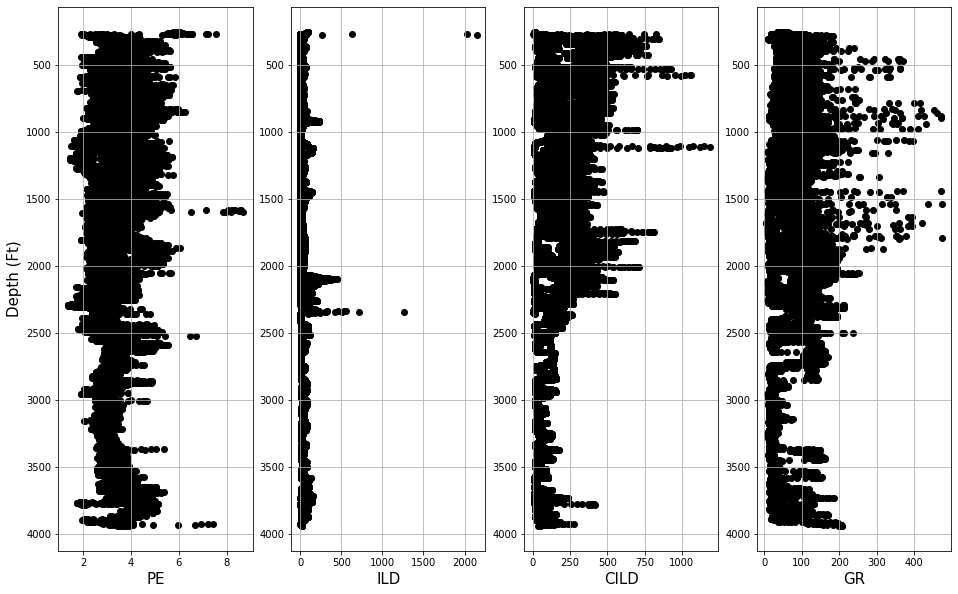

In [13]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(16,10),linewidth=3)

curves = ['PE','ILD','CILD','GR']

for i in range(len(curves)):
    ax[i].scatter(df2[curves[i]],df2['DEPT'],c='k')
    ax[i].set_xlabel(curves[i],fontsize=15)
    ax[0].set_ylabel('Depth (Ft)',fontsize=15)
    ax[i].yaxis.grid(True)
    ax[i].xaxis.grid(True)
    ax[i].invert_yaxis()

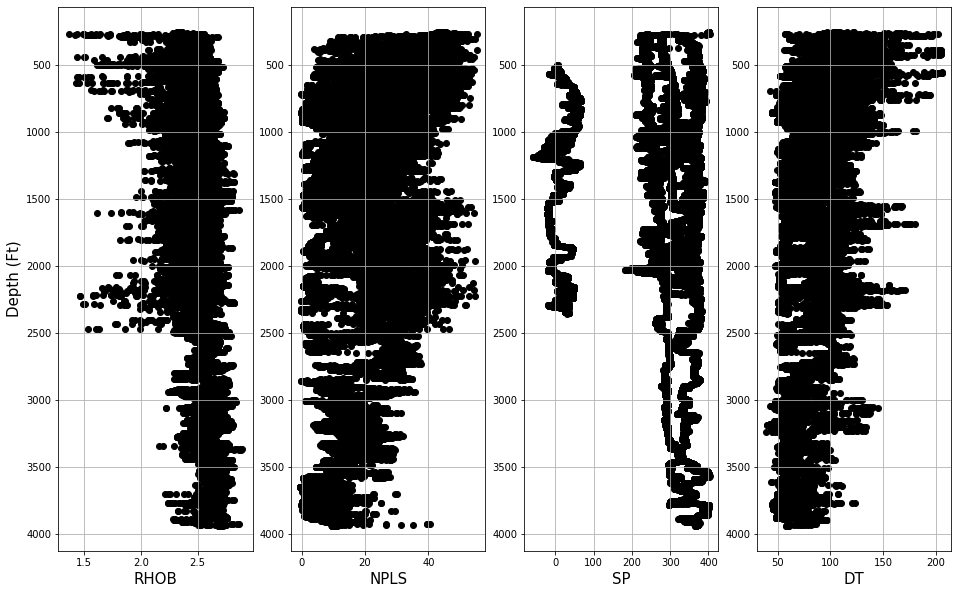

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(16,10),linewidth=3)

curves = ['RHOB','NPLS','SP','DT']

for i in range(len(curves)):
    ax[i].scatter(df2[curves[i]],df2['DEPT'],c='k')
    ax[i].set_xlabel(curves[i],fontsize=15)
    ax[0].set_ylabel('Depth (Ft)',fontsize=15)
    ax[i].yaxis.grid(True)
    ax[i].xaxis.grid(True)
    ax[i].invert_yaxis()


A lot of variability can be observed in the **CILD** and **ILD** readings. We can decrease the variability in the resistivity and 
conductivity by applying a natural logarithmic transformation

In [15]:
df2['Log_ILD'] = np.log(df2['ILD'])
df2['Log_CILD'] = np.log(df2['CILD'])

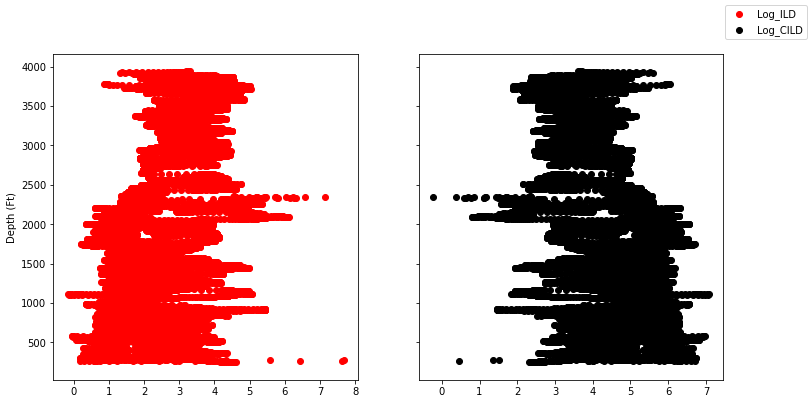

In [16]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,6),sharey=True)
ax[0].scatter(df2['Log_ILD'],df2['DEPT'],label='Log_ILD',c='r')
ax[0].set_ylabel('Depth (Ft)')
ax[1].scatter(df2['Log_CILD'],df2['DEPT'],label='Log_CILD',c='k')
fig.legend();

As some lithologies may result in big spikes in certain physical measurements (e.g. **ILD**, **CILD**), the natural log was opted for to minimize the variability in measurement values. This was applied to the **ILD** and **CILD** logs due to the large range in their values. Finally, the processed logs were saved to a CSV file.

Finally we can output our results into a CSV file

In [17]:
df2.reset_index(drop=True,inplace=True)
df2.to_csv("Kinney_oil_ML_processed.csv")

## K-means Clustering for Facies identification

In [18]:
df2 = pd.read_csv("Kinney_oil_ML_processed.csv")

In [19]:
df2.drop(columns=['Unnamed: 0'],inplace=True)
df2.head()

,DEPT,GR,CILD,RHOB,NPLS,PE,ILD,SP,DT,Formation,Well name,Log_ILD,Log_CILD
0,265.4,57.65,47.62,2.11,48.98,7.57,31.66,317.30,77.27,Unknown,BAUMGARTNER 1-23 #1,3.455054,3.863253
1,267.9,53.05,18.80,1.61,41.22,4.33,2032.80,296.74,111.55,Unknown,BAUMGARTNER 1-23 #1,7.617169,2.933857
2,268.4,55.89,74.38,1.44,41.59,3.27,17.70,286.09,121.62,Unknown,BAUMGARTNER 1-23 #1,2.873565,4.309187
3,268.9,63.60,159.65,1.37,40.57,2.74,6.80,278.63,127.30,Unknown,BAUMGARTNER 1-23 #1,1.916923,5.072984
4,269.4,77.40,315.11,1.42,39.56,2.53,3.41,273.74,127.67,Unknown,BAUMGARTNER 1-23 #1,1.226712,5.752922


The features needed for clustering are then selected.

In [20]:
features = df2.drop(columns=['Formation','Well name','ILD','CILD','DEPT'])
features

,GR,RHOB,NPLS,PE,SP,DT,Log_ILD,Log_CILD
0,57.65,2.11,48.98,7.57,317.30,77.2700,3.455054,3.863253
1,53.05,1.61,41.22,4.33,296.74,111.5500,7.617169,2.933857
2,55.89,1.44,41.59,3.27,286.09,121.6200,2.873565,4.309187
3,63.60,1.37,40.57,2.74,278.63,127.3000,1.916923,5.072984
4,77.40,1.42,39.56,2.53,273.74,127.6700,1.226712,5.752922
...,...,...,...,...,...,...,...,...
23710,147.25,2.59,22.70,2.66,33.82,59.2489,4.576153,2.331173
23711,149.26,2.60,22.88,2.72,33.24,59.2261,4.567364,2.340844
23712,151.65,2.61,22.75,2.72,32.72,59.2270,4.566429,2.340844
23713,150.81,2.62,22.57,2.80,32.35,59.2330,4.568506,2.338917


Before we proceed, we check the degree of collinearity amongst the features. We use the corr function

In [21]:
features.corr()

,GR,RHOB,NPLS,PE,SP,DT,Log_ILD,Log_CILD
GR,1.000000,-0.431120,0.592791,-0.135289,0.175288,0.651232,-0.581829,0.582285
RHOB,-0.431120,1.000000,-0.705226,0.398047,-0.045750,-0.630215,0.648362,-0.650038
NPLS,0.592791,-0.705226,1.000000,-0.420358,0.087767,0.777115,-0.777155,0.778252
PE,-0.135289,0.398047,-0.420358,1.000000,0.386078,-0.261417,0.334754,-0.334635
SP,0.175288,-0.045750,0.087767,0.386078,1.000000,0.130642,-0.169375,0.169626
DT,0.651232,-0.630215,0.777115,-0.261417,0.130642,1.000000,-0.680928,0.681818
Log_ILD,-0.581829,0.648362,-0.777155,0.334754,-0.169375,-0.680928,1.000000,-0.999655
Log_CILD,0.582285,-0.650038,0.778252,-0.334635,0.169626,0.681818,-0.999655,1.000000


Right away it is evident that the logarithmic resistivity and conducitivty logs are basically providing very similar information due to their high correlation. We should therefore drop one of the variables. Some other features had fairly high correlations which implies some collinearity. This was expected as some of the logs measure similar physical properties. However, they also serve as good lithology differentiators in certain cases e.g **NPLS** logs are excellent gas detectors while DT measures general porosity. So they were retained

In [22]:
features.drop(columns=['Log_CILD'],inplace=True)

Next we scale the data. Let's import the libraries that will help us with this task

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

In [24]:
x_scaled = scale(features)
x_scaled

array([[-0.34724289, -2.37639478,  2.30238075, ...,  0.40420131,
        -0.34480339,  1.02107158],
       [-0.43739739, -5.51854029,  1.65410275, ...,  0.22882152,
         0.95402297,  4.89555542],
       [-0.38173679, -6.58686977,  1.68501291, ...,  0.13797547,
         1.33556268,  0.47976719],
       ...,
       [ 1.49504478,  0.76575073,  0.11110087, ..., -2.02330745,
        -1.02843011,  2.05564301],
       [ 1.47858178,  0.82859364,  0.0960635 , ..., -2.02646361,
        -1.02820278,  2.05757633],
       [ 1.44565579,  0.89143655,  0.0626471 , ..., -2.02953446,
        -1.02810806,  2.05776944]])

The issue with clustering is we have no idea which cluster seperation is the most accurate representation of our data.
Therefore we emply two techniques that can give us an idea of what the optimal cluster size could bes. We start of with the Elbow technique. This method runs K-means clustering for a specified number of clusters, and for each cluster calculates the within sum of squares i.e the sum of differences between each point in a cluster and its assigned cluster centroid. The optimal cluster is usually selected as the point in which the sum of squares is minimized and subsequent changes for increasing clusters are minimal.

Let's make an analysis of for clusters ranging in size from 1 to 12

In [25]:
wcss = []

cl_num = 12
for i in range (1,cl_num):
    kmeans= KMeans(i, random_state=10)
    kmeans.fit(x_scaled)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
wcss

[166005.0,
 99182.35613276341,
 81016.72838632036,
 71062.94235648407,
 63233.304798218385,
 57061.3523787356,
 52007.98333361915,
 48540.807668033245,
 45529.579604930266,
 42946.617477353844,
 40600.3523364267]

Text(0, 0.5, 'Within-cluster Sum of Squares')

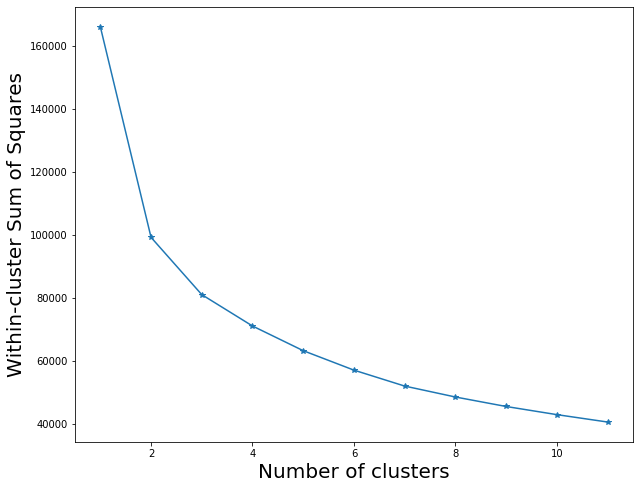

In [26]:
number_clusters = range(1,cl_num)
plt.figure(figsize=(10,8))
plt.plot(number_clusters, wcss,'*-' )
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('Within-cluster Sum of Squares',fontsize=20)

Although not very apparent, we can see the curve begin to somwhat flatten aroud no of clusters >= 6 mark. We can further evaluate the optimal cluster size by looking at the silhouette score. 

The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Silhouette coefficients near 1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.


In [27]:
from sklearn.metrics import silhouette_score

In [28]:
range_n_clusters = [5,6,7,8,9,10,11]

for n_clusters  in range_n_clusters:
     
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_scaled)
    
    silhouette_avg = silhouette_score(x_scaled, cluster_labels)
    
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    

For n_clusters = 5 The average silhouette_score is : 0.25127876457753867
For n_clusters = 6 The average silhouette_score is : 0.26492699199362446
For n_clusters = 7 The average silhouette_score is : 0.25374235816210383
For n_clusters = 8 The average silhouette_score is : 0.265051906043012
For n_clusters = 9 The average silhouette_score is : 0.2488913386870333
For n_clusters = 10 The average silhouette_score is : 0.2566742138994046
For n_clusters = 11 The average silhouette_score is : 0.25161428102825306


The silhouette score has its highest values at n_clusters = 8. We then proceed to cluster the curves using this value. The value of 6 was very close but having more seperation is better in facies identification. This is due to the fact that some lithologies tend to get interbedded with each other so more clusters might reveal these patterns. I utilize 100 random initial centroids to increase probability of finding a reasonable cluster seperation. 

In [29]:
kmeans_ = KMeans(8,n_init=100)
kmeans_.fit(x_scaled) 
df2['Facies_pred']=kmeans_.fit_predict(x_scaled) 

We will now plot the facies using codes modified from [Brendan Hall](https://github.com/seg/2016-ml-contest/blob/master/Facies_classification.ipynb). Note: The top of each formation is highlighted by the formation name

In [35]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import matplotlib as mpl
import seaborn as sns

In [32]:
#del facies_colors, facies_labels

facies_colors = ['r', 'b','g','#6E2C00',
       '#1B4F72','k', '#AED6F1', '#A569BD']

facies_labels = [0, 1, 2, 3, 4, 5, 6,7]

# facies_colors = ['r', 'b','g','#6E2C00',
#        '#1B4F72','k']

# facies_labels = [0, 1, 2, 3, 4,
#                  5]

In [33]:
# Get list of well names
wells = df2['Well name'].unique()
wells

array(['BAUMGARTNER 1-23 #1', 'HARTTER #1-34', 'LAUB 1-15 #1',
       'PLATTNER #1-10', 'Woody Acres No. 1-2'], dtype=object)

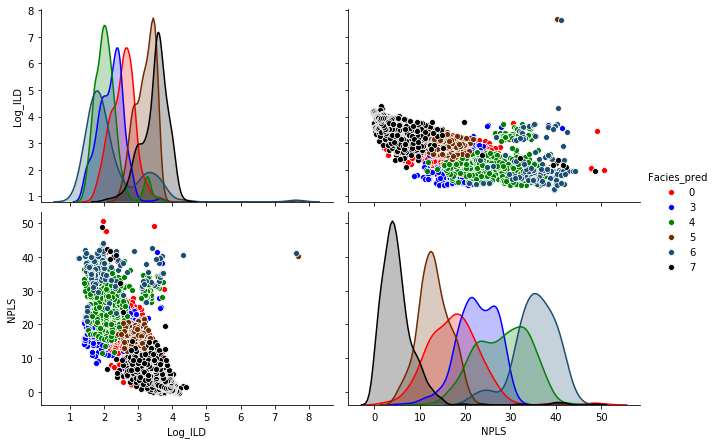

In [36]:
# Make cross plot of some curves for a given well
temp = df2[['Log_ILD','NPLS','Facies_pred']]
Well_data = temp[df2['Well name'] == wells[0]]
Well_data

sns.pairplot(Well_data,
             hue='Facies_pred',palette=facies_colors,height=3.0,aspect=1.5);

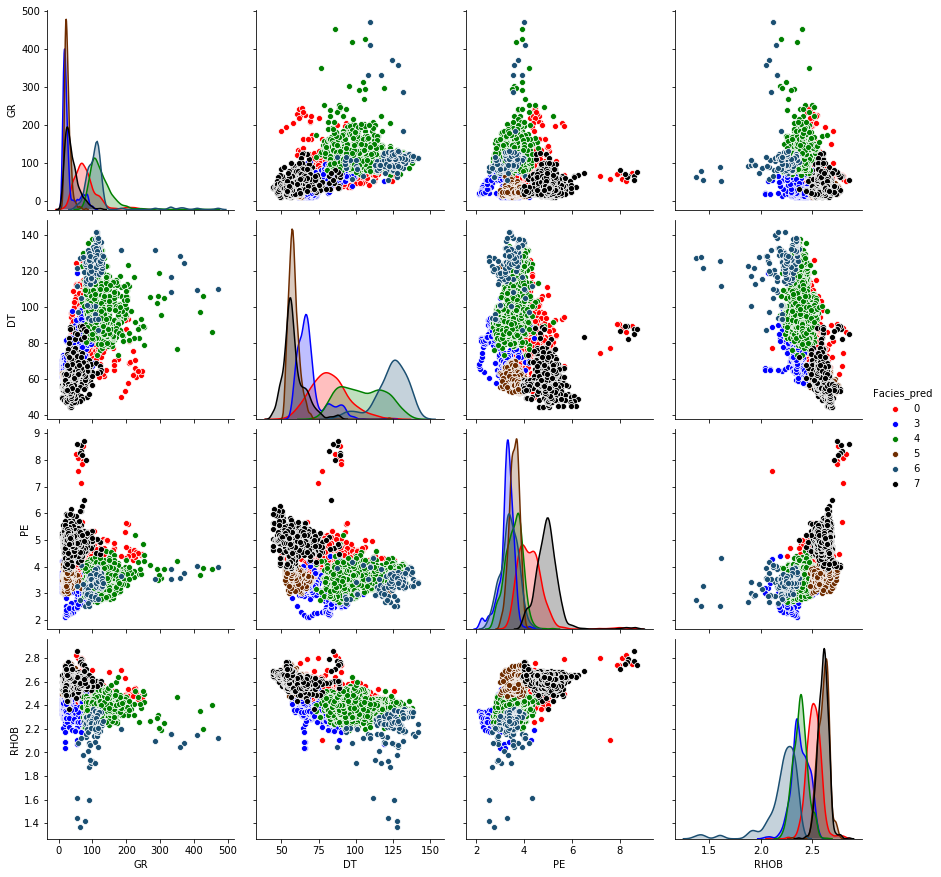

In [37]:
# Make cross plot of some curves for a given well
temp = df2[['GR','DT','PE','RHOB','Facies_pred']]
Well_data = temp[df2['Well name'] == wells[0]]
Well_data

sns.pairplot(Well_data,
             hue='Facies_pred',palette=facies_colors,height=3.0,aspect=1.0);

Note: The facies labels use python's indexing convention which starts from 0 

In [48]:
def make_facies_log_plot(logs, facies_colors,Formation_name,top):
    
    logs = logs.sort_values(by='DEPT')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.DEPT.min(); zbot=logs.DEPT.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies_pred'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(19, 16))
    ax[0].plot(logs.GR, logs.DEPT, '-g',linewidth=2)
    ax[1].plot(logs.NPLS, logs.DEPT, '-',linewidth=2)
    ax[2].plot(logs.RHOB, logs.DEPT, '-', color='0.5',linewidth=2)
    ax[3].plot(logs.DT, logs.DEPT, '-', color='r',linewidth=2)
    ax[4].plot(logs.PE, logs.DEPT, '-', color='black',linewidth=2)
    ax[5].plot(logs.Log_ILD, logs.DEPT, '-', color='purple',linewidth=2)
    im=ax[6].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=8)
#     im=ax[6].imshow(cluster, interpolation='none', aspect='auto',
#                     cmap=cmap_facies,vmin=1,vmax=6)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((30*' ').join(['1', '2', 
                                '3', '4 ', ' 5 ', ' 6  ', 
                                ' 7 ','8']))
#     cbar.set_label((35*' ').join(['1', '2', 
#                                  '3', '4 ', ' 5 ', ' 6  ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    
    
    tick_inter = [80,10,0.3,20, 1.1,1.0]
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid(which='minor',axis='both')
        ax[i].locator_params(axis='x', nbins=3)
        
        
    tops = len(Formation_name)
    
    for k in range(tops):
                
    
        ax[0].set_xlabel("GR (api)",fontsize=15)
        ax[0].set_xlim(logs.GR.min(),logs.GR.max())
        ax[0].xaxis.set_ticks(np.arange(0, int(logs.GR.max()), tick_inter[0]))
        ax[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0i'))
        y = top[k] * np.ones((len(logs.GR),1))
        x = logs.GR
        ax[0].plot(x,y,'y',linewidth=1)
        ax[0].text(200,top[k]-10,Formation_name[k],fontsize=12,bbox=dict(facecolor='yellow', alpha=0.05))

        ax[1].set_xlabel("NPLS (%)",fontsize=15)
        ax[1].set_xlim(logs.NPLS.min(),logs.NPLS.max())
        ax[1].xaxis.set_ticks(np.arange(0, int(logs.NPLS.max()), tick_inter[1]))
        ax[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0i'))
        y = top[k] * np.ones((len(logs.NPLS),1))
        x = logs.NPLS
        ax[1].plot(x,y,'y',linewidth=1)

        ax[2].set_xlabel("RHOB (g/cm^{3})",fontsize=15)
        ax[2].set_xlim(logs.RHOB.min(),logs.RHOB.max())
        ax[2].xaxis.set_ticks(np.arange(logs.RHOB.min(), (logs.RHOB.max()), tick_inter[2]))
        ax[2].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
        y = top[k] * np.ones((len(logs.RHOB),1))
        x = logs.RHOB
        ax[2].plot(x,y,'y',linewidth=1)

        ax[3].set_xlabel("DT (μs/ft)",fontsize=15)
        ax[3].set_xlim(logs.DT.min(),logs.DT.max())
        ax[3].xaxis.set_ticks(np.arange(logs.DT.min(), int(logs.DT.max()), tick_inter[3]))
        ax[3].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0i'))
        y = top[k] * np.ones((len(logs.DT),1))
        x = logs.DT
        ax[3].plot(x,y,'y',linewidth=1)

        ax[4].set_xlabel("PE (b/E)",fontsize=15)
        ax[4].set_xlim(logs.PE.min(),logs.PE.max())
        ax[4].xaxis.set_ticks(np.arange(logs.PE.min(), (logs.PE.max()), tick_inter[4]))
        ax[4].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
        y = top[k] * np.ones((len(logs.PE),1))
        x = logs.PE
        ax[4].plot(x,y,'y',linewidth=1)
        
        ax[5].set_xlabel("Log_ILD (Ω/m)",fontsize=15)
        ax[5].set_xlim(logs.Log_ILD.min(),logs.PE.max())
        ax[5].xaxis.set_ticks(np.arange(logs.Log_ILD.min(), (logs.Log_ILD.max()), tick_inter[5]))
        ax[5].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
        y = top[k] * np.ones((len(logs.Log_ILD),1))
        x = logs.Log_ILD
        ax[5].plot(x,y,'y',linewidth=1)

        ax[6].set_xlabel('Facies',fontsize=15)

        ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
        ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
        ax[6].set_xticklabels([])
        f.suptitle('Well: %s'%logs.iloc[0]['Well name'], fontsize=14,y=0.94)
        
    #f.tight_layout()


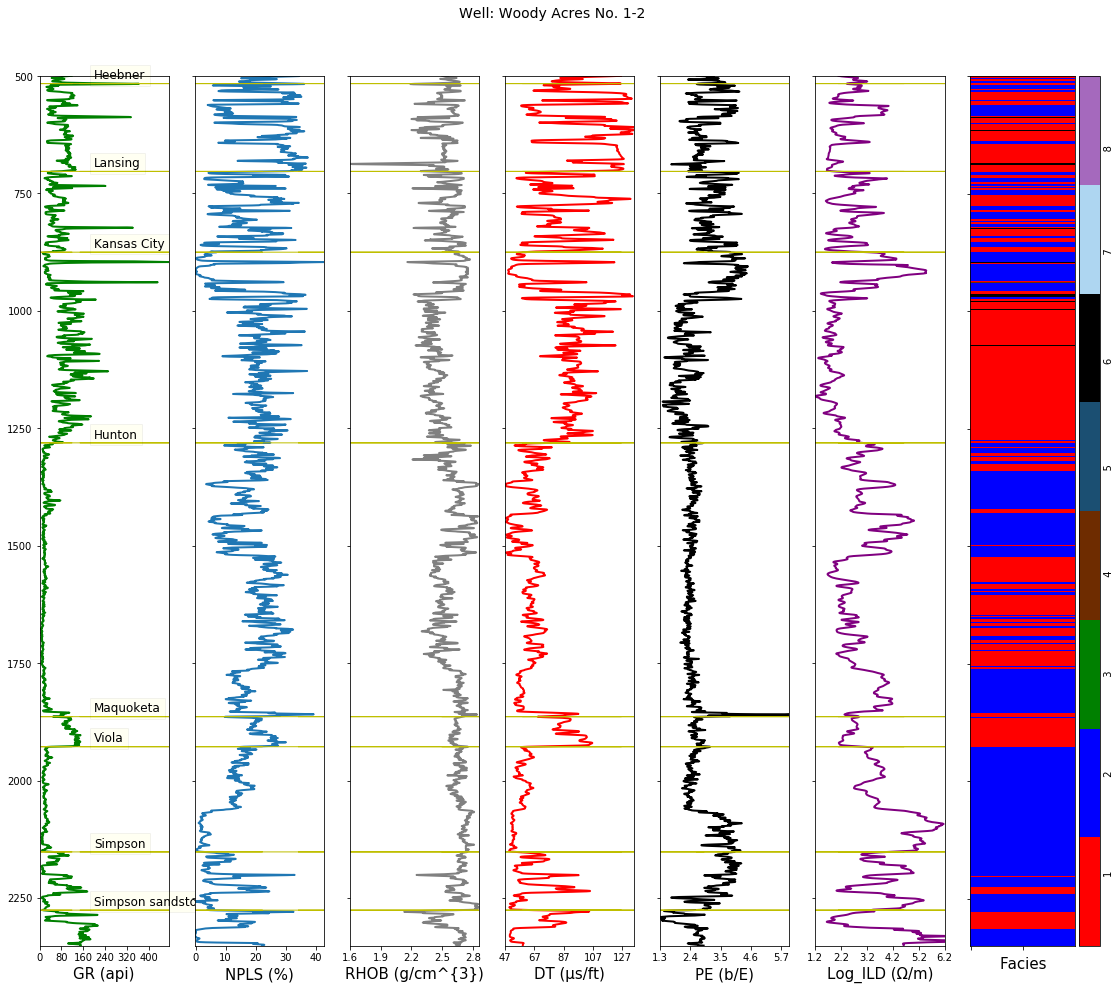

In [49]:
                        # Woody Acres
Formation_name= ['Heebner','Lansing','Kansas City','Hunton','Maquoketa','Viola','Simpson','Simpson sandstone']
top = [516,703,875,1281,1864,1928,2152,2276]

make_facies_log_plot(
    df2[df2['Well name'] == wells[4]],
    facies_colors,Formation_name,top)

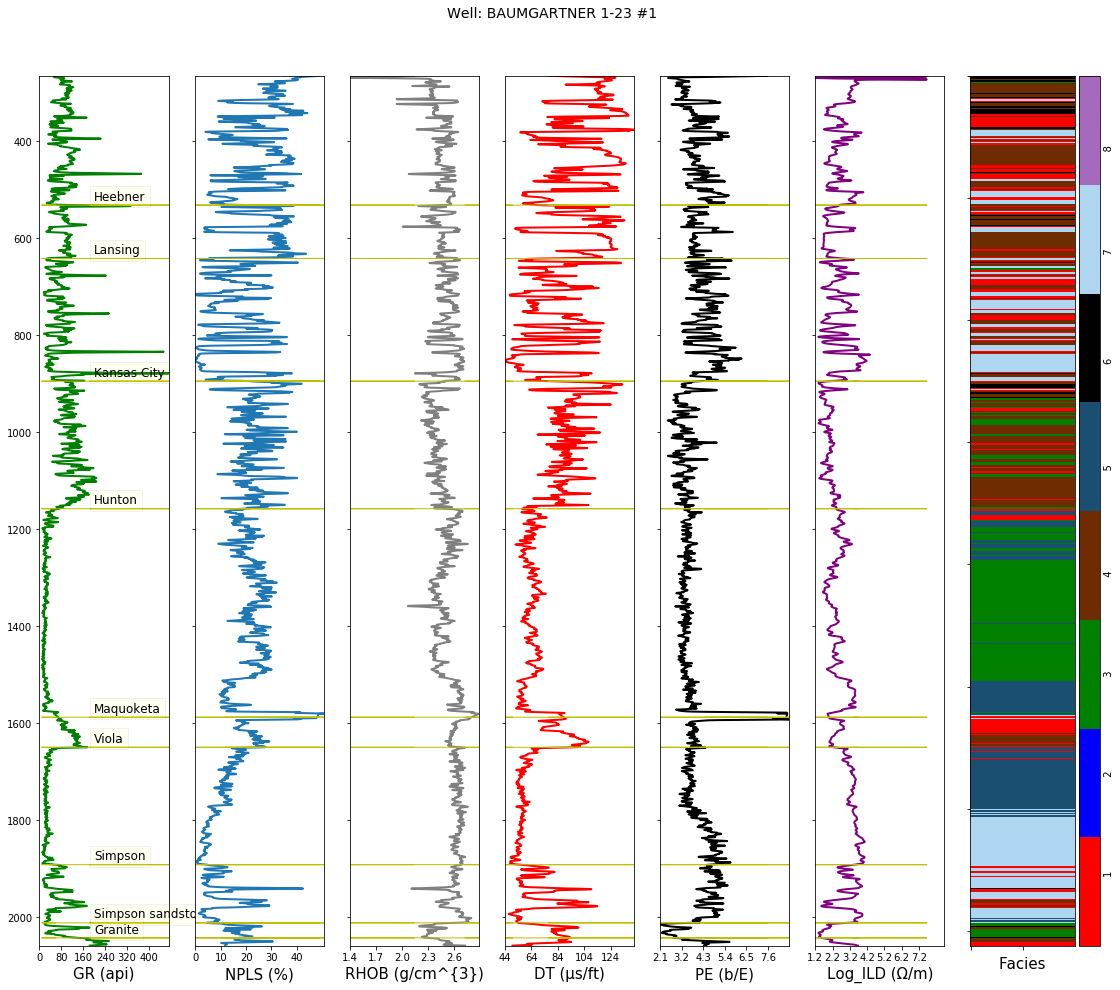

In [50]:
                        # Baumgartner
Formation_name = ['Heebner','Lansing','Kansas City','Hunton','Maquoketa','Viola','Simpson','Simpson sandstone','Granite']
top = [532,642,895,1158,1588,1650,1892,2012,2043]

make_facies_log_plot(
    df2[df2['Well name'] == wells[0]],
    facies_colors,Formation_name,top)

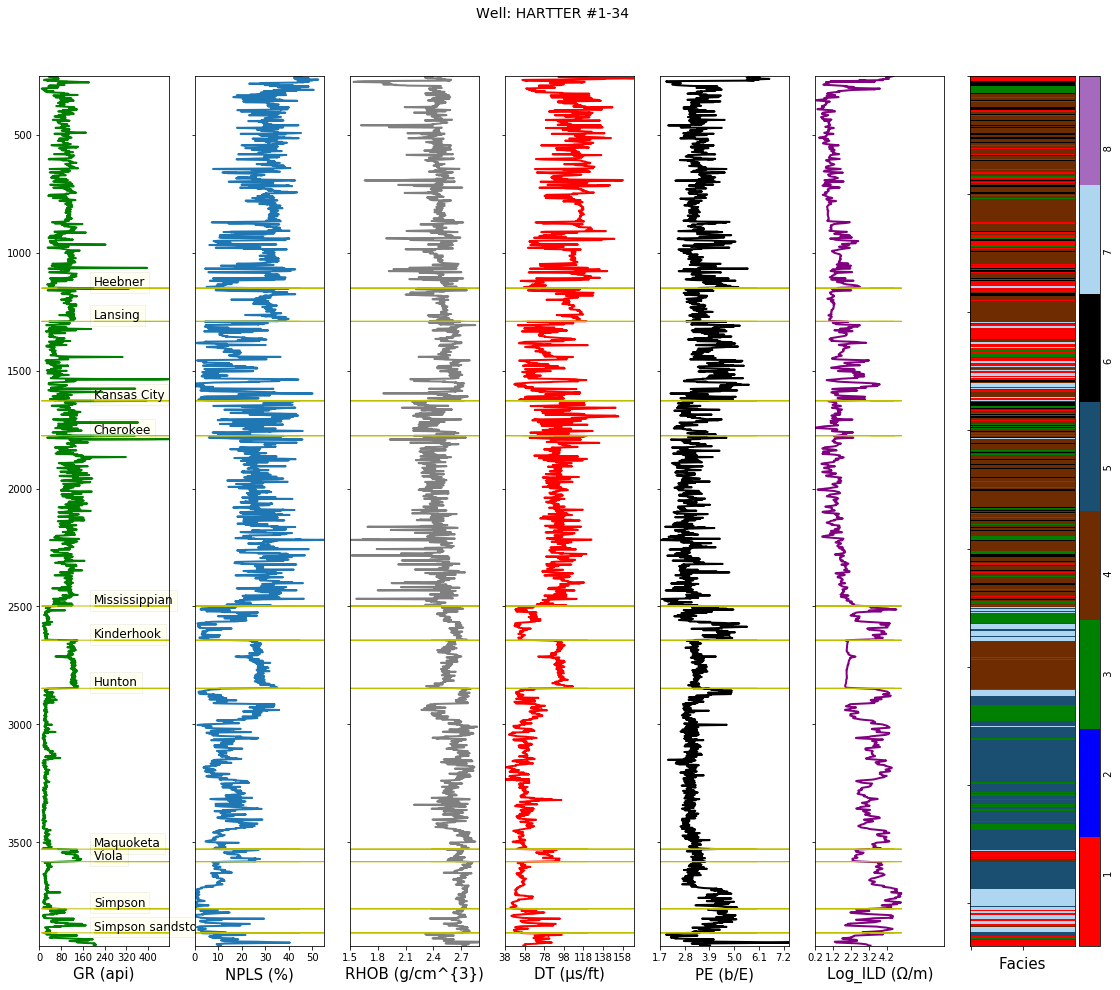

In [51]:
                        # Hartter
Formation_name= ['Heebner','Lansing','Kansas City','Cherokee','Mississippian','Kinderhook','Hunton','Maquoketa','Viola','Simpson','Simpson sandstone']
top = [1150,1291,1628,1776,2498,2643,2847,3529,3582,3782,3884]#3930,3945,3978]

make_facies_log_plot(
    df2[df2['Well name'] == wells[1]],
    facies_colors,Formation_name,top)

The plots show there is lateral variation of the lithologies in this region. We can validate these results by obtaining some knowledge of the kansas stratigraphy. According to [KGS geology](http://www.kgs.ku.edu/Publications/Bulletins/Sub9/page2.html), the dominant lithologies in this region are; sandstones, shales, dolomite, limestones with some silt, chert and chalk. Analysis of core samples also includes gypsium and pyrite amongst others. Our analysis highlighted 8 facies which are reasonable results based on the known information. Different rocks have different well log responses, and these responses used in combination can give us a pretty good idea of what the underlying lithology is. Different log responses for different lithologies can be found [here](https://www.geoloil.com/VshFromNeutrDens.php) and [here](http://www.kgs.ku.edu/Publications/Bulletins/LA/05_overlay.html). 

If we consider the Viola formation for instance, in the Woody Acres well its represented predominantly by **Facies 2**. It is characterized by extremly low gamma ray values, density values between 2.5-2.8 g/cm<sup>3</sup>, DT values on the low end (47-67 µs/ft). The PE values occur in show a jump half way in the formation suggesting the presence of another lithology, but its overall properties suggest a **dolomitic layer** with some limestones inclusions in it. In the Baumgartner well, the PE values in the bottom half of the formation jump towards a value of 5 b/E, which is indicative of limestones. The top half shows similar properties to dolomite in terms of the PE value, and its decreasing Neutron porosity coupled with a relatively stable density suggests this facies to be a combination of dolomites and limestones i.e a dolomitic limestone layer. We can therefore attribute **Facies 7** and **5** as **limestone** and **dolomitic limestone** respectively. 

The Kinderhook formation in the Hartter well shows a jump in the gamma readings, an increase in neutron porosity, with   realtively stable density readings and a much lower resistivity reading. The sudden increase in the sonic porosity in addition to the previously mentioned properties point to a **shale** layer for **Facies 4**. The Viola formation in this well also has very similar properties, but the sonic porosity values are lower, and the slightly higher resistivity values compared to the kinderhook formation suggest the inclusion of sands, limestone or dolomites. However, the PE values are lower than that of dolomites or limestones suggesting **Facies 1** is a **sandy shale** layer.  Finally, the low gamma values in the top parts of the Hunton formation, coupled with the drop in the neutron porosity and increase in density and PE values in the dolomitic range suggest a **dolomitic sand** regime for **Facies 3**. 

Reference to [KGS geology](http://www.kgs.ku.edu/Publications/Bulletins/Sub9/page2.html) reveals the Viola formation to be composed of fine to coarse-grained limestones and dolomites containing variable quantities of chert. It also highlights the Hunton formation to be generally composed of gray to brown, fine-grained, crystalline dolomite or limestone with minor chert in some parts. It is also slightly coarser grained, and slightly sandy dolomite with vuggy porosity with some chert in other parts of the formation. These agree with our analysis which show limestones and dolomites consistitute the majority of these formations.

## Summary

Unsupervised machine learning can be a great way to derive some quick insights from your data in a cost-effective manner and could be a guide for additional supervised work as demonstrated in this study. However, as attractive as the prospects of this technique are, it is important to be aware of the caveats associated with this method.
The optimal number of clusters is not easy to predict and can be subjective in most cases. Most lithologies are not completely homogenous and tend to include different rock types, so finding an optimal k value is difficult and sometimes not possible, and may require some a priori knowledge. Additionally, the clusters can change depending on the initial centroid starting location. It is also not a practical solution for situations where there is an enormous amount of data. In those cases, it is preferable to use supervised learning techniques. In future work, I will demonstrate how a convolutional neural network can be applied to facies classification, as well as evaluating its effectiveness in terms of accuracy and other metrics.
Comments and feedback are welcome.

Thank you!